In [1]:
import numpy as np
from ase.io import read
from dask.distributed import Client

from abtem.waves import Waves, PlaneWave, Probe
from abtem.potentials.temperature import FrozenPhonons
from abtem.potentials import Potential
from abtem import GridScan, AnnularDetector

import os
os.environ['MKL_NUM_THREADS'] = '1'

# abTEM and Dask

Parallel computation in abTEM whether it is running on laptop, a GPU or on a High Performance Computing cluster goes through [Dask](https://dask.org/). Basic knowledge of Dask may be required to run abTEM effectively on large multi-CPU/GPU systems, however, if you are just running abTEM on your own computer, this short tutorial should suffice.

## Delayed computations

Computations in abTEM are _delayed_ (or sometimes called _lazy_) by default, this means that "building" the probe wave function only creates the instructions, or task graph, for making that probe.

In [4]:
probe = Probe(energy=80e3, extent=10, gpts=256, semiangle_cutoff=30)

build_probe = probe.build()

build_probe.array

dask.array<ifft2, shape=(1, 256, 256), dtype=complex64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>

If you want the numpy array you have to compute the probe.

In [5]:
build_probe.compute()

type(build_probe.array)

numpy.ndarray

An advantage of using Dask is that you can create your task graph first, and then decide when to compute. For example, below we create a task graph for running the multislice algorithm for probe wave functions placed on a grid. The result is a 2d grid of 2d wave functions represented as a 4d array.

In [6]:
atoms = read('data/orthogonal_graphene.cif') 

potential = Potential(atoms, chunks=100)

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=probe.ctf.nyquist_sampling * .5)

exit_waves = probe.multislice(potential, gridscan)

exit_waves.array

dask.array<_multislice, shape=(15, 25, 256, 256), dtype=complex64, chunksize=(15, 16, 256, 256), chunktype=numpy.ndarray>

Dask arrays are composed of many NumPy arrays (or CuPy arrays on gpu). In this example, the 4d array is 750 mb of memory, however it is split into chunks of 128 mb. This lets us compute on arrays larger than memory using all of our cores.

It is important to note the 4d array is not currently taking up any memory, and will never (necessarily) be fully in memory, unless you decide to compute it. However, usually we don't need the wave functions, we want the intensity detected by a given detector configuration.

In STEM-HAADF we detect the integrated intensity of the diffraction patterns over an annular disk. The code below, tasks the task graph from above and continues it, as you can see the resulting array is greatly reduced.

In [7]:
diffraction_patterns = exit_waves.diffraction_patterns()

measurement = diffraction_patterns.integrate_annular_disc(50, 150)

measurement.array

dask.array<integrate_fourier_space, shape=(15, 25), dtype=float32, chunksize=(15, 16), chunktype=numpy.ndarray>

We can finally call compute, which will trigger the calculation to start.

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f3be01d5d30>)

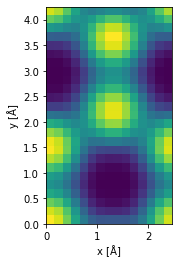

In [8]:
measurement.compute()

measurement.show()

## Diagnostic dashboard

Dask provides a [diagnotic dashboard](https://docs.dask.org/en/latest/diagnostics-distributed.html) containing many plots and tables with live information.

In [ ]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

The dashboard is typically served at http://localhost:8787/status, but may be served elsewhere if this port is taken. If you are using Jupyter Lab the [Dask labextension](https://github.com/dask/dask-labextension) provides the same information more conveniently.

## Showing the computational graph

Plotting the computational graph may occasionally be useful. Note that the visualize function is powered by the [GraphViz](https://www.graphviz.org/) system library.

In [3]:
diffraction_patterns.integrate_annular_disc(50, 150).visualize_graph(rankdir='LR')

NameError: name 'diffraction_patterns' is not defined